In [28]:
# Imports
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from tqdm import tqdm
from ucimlrepo import fetch_ucirepo


sns.set_style("dark")
warnings.filterwarnings("ignore")
plt.rcParams['axes.grid'] = True

In [29]:
# Constants

CMAP = "YlGnBu"
TARGET = "income"
BATCH_SIZE = 32
FILES = "files/"

In [30]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X_base = adult.data.features 
y_base = adult.data.targets 

In [31]:
X = X_base.copy()
y = y_base.copy()

### dataset analysis

Link: http://archive.ics.uci.edu/dataset/2/adult

In [32]:
print(f"Dataset size: {X.shape[0]}")
print("Example:")
X.head()

Dataset size: 48842
Example:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [33]:
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
total_features = list(X.columns)

In [34]:
# Let's check X integrity
# Change all strange values in 
# categoricaal columns to null

X[X == '?'] = np.NaN

print("Amount of missing values in every feature:")
print(X.isna().sum())

# as we can see, column 'workclass', 'occupation', 'native-country' have NaN values

Amount of missing values in every feature:
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64


In [35]:
# target column has only two values
# so, it's Rregression task

print("Target column values:")
print(*y['income'].drop_duplicates().values)

# let's drop point
y['income'] = y['income'].apply(lambda x: x.replace(".", ""))
print("Target column values corrected:")
print(*y['income'].drop_duplicates().values)

Target column values:
<=50K >50K <=50K. >50K.
Target column values corrected:
<=50K >50K


In [36]:
####################
### Task:
#####################
# Prediction task is to determine whether a person makes over 50K a year.
# Features:
### Numerical: age, fnlwgt, education-num, capital-gain, capital-loss, hours-per-week
### Categorical: workclass, education, marital-status, occupation, relationship, race, sex, native-country

### Data Visualization
#### Source: https://en.wikipedia.org/wiki/Quartile

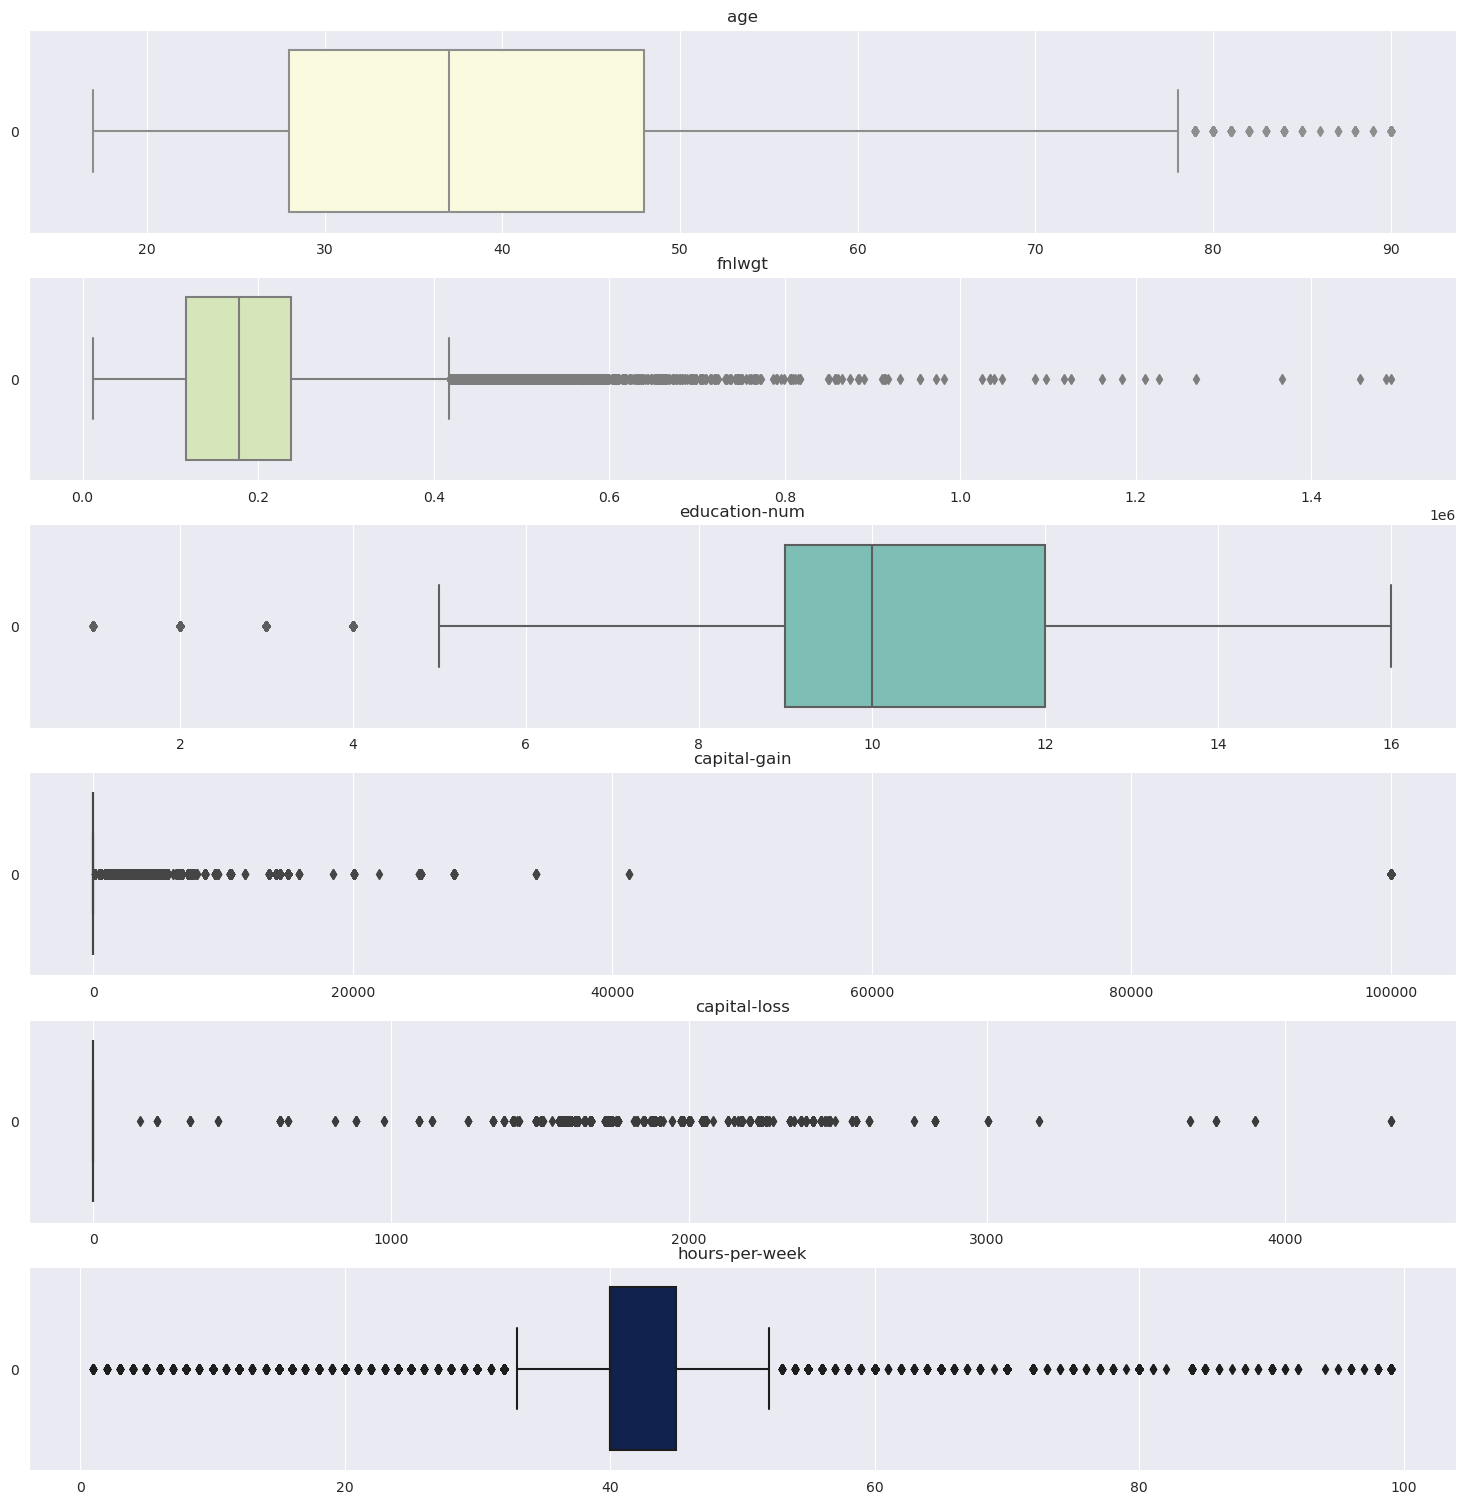

In [37]:
# numeric X visualization with Box-and-Whisker
n = len(numerical_features)

fig, axes = plt.subplots(n)
fig.set_size_inches(15, 15)
fig.tight_layout()

cmap = plt.get_cmap(CMAP)
colors = [cmap(i) for i in np.linspace(0, 1, n)]

for (ax, col, color) in zip(axes, numerical_features, colors):
    sns.boxplot(data=X[col].values, orient='h', ax=ax, color=color).set_title(col)
    

plt.show()

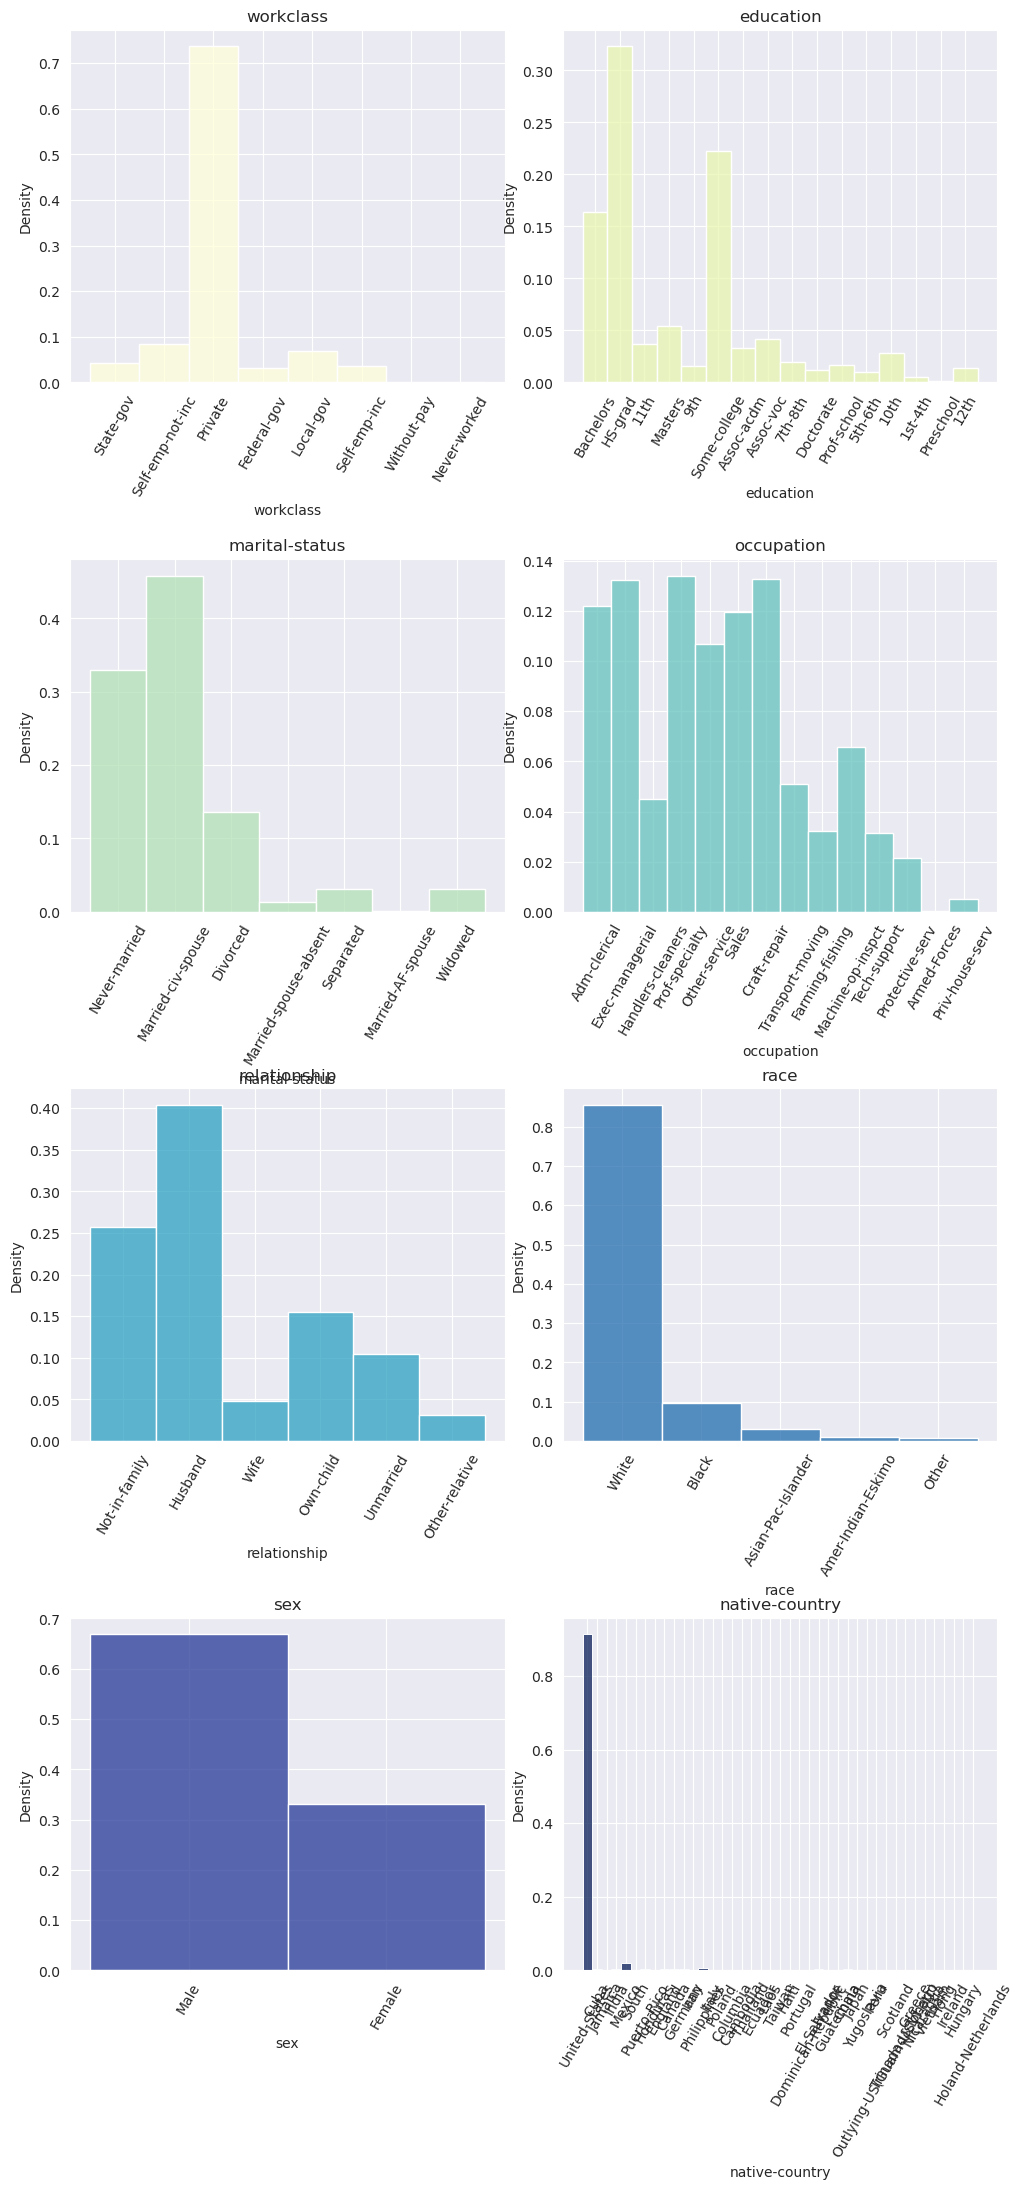

In [38]:
# hists for categorical features

m = len(categorical_features)

n_row = 4
if m % n_row != 0:
    raise ValueError("Not int")
n_col = int(m / n_row)

fig, axes = plt.subplots(n_row, n_col)
fig.set_size_inches(n_col * 5, n_row * 5)
fig.tight_layout()
plt.subplots_adjust(hspace = 0.5)

cmap = plt.get_cmap(CMAP)
colors = [cmap(i) for i in np.linspace(0, 1, m)]

for (ax, col, color) in zip(axes.flatten(), categorical_features, colors):
    sns.histplot(data=X, x=col, ax=ax, color=color, stat='density').set(title=col)
    ax.tick_params(axis='x', labelrotation=60)

plt.show()

In [39]:
# let's see more carefully to 'native-country' column
nc = X['native-country'].value_counts().reset_index()
nc['ttl'] = nc['count'].sum()
nc['share, %'] = 100 * nc['count'] / nc['ttl']
nc.head(1)

,native-country,count,ttl,"share, %"
0,United-States,43832,47985,91.345212


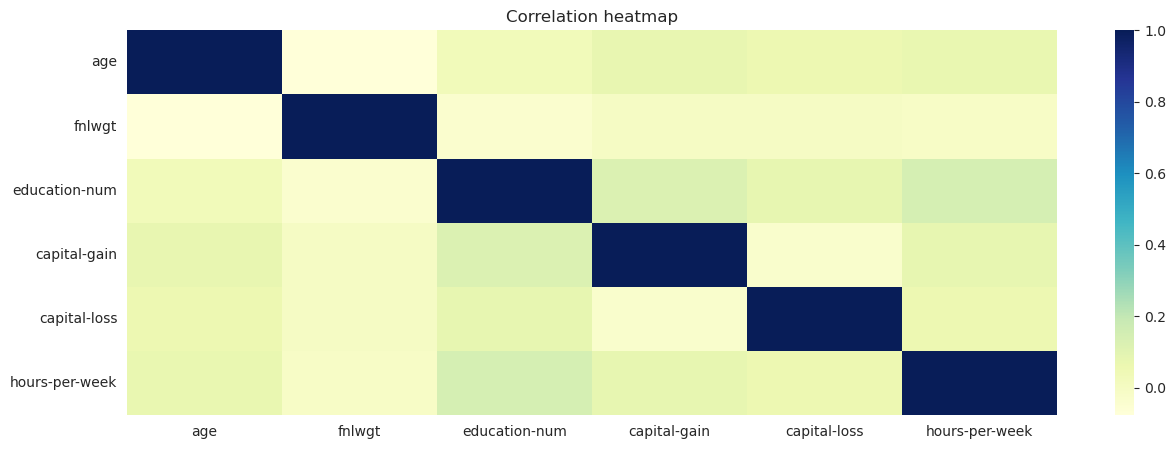

In [40]:
# correlation heatmap

fig = plt.figure(figsize=(15, 5))    
corr = X[numerical_features].corr()
sns.heatmap(corr, cmap=CMAP)
plt.title("Correlation heatmap")
plt.show()

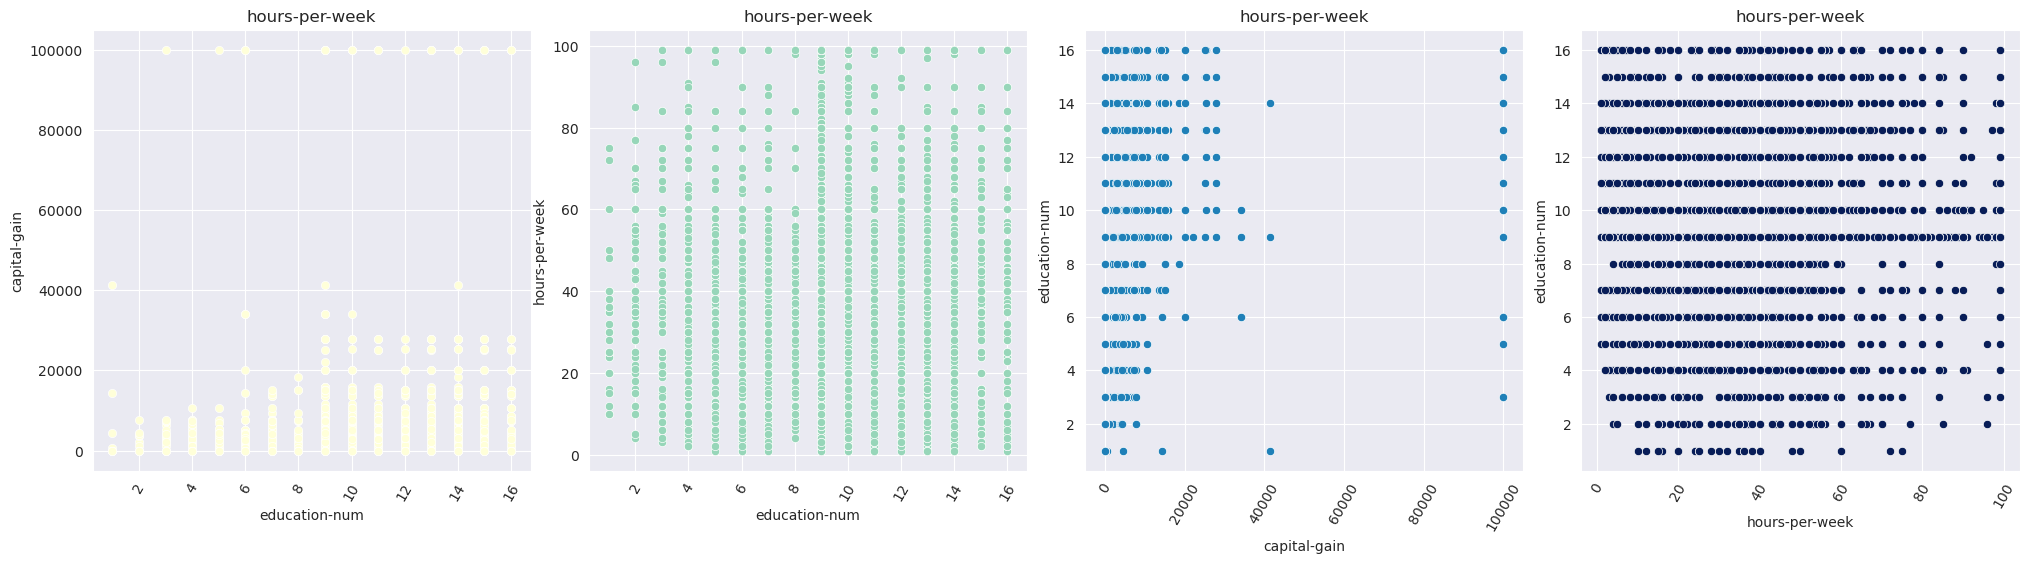

In [41]:
# scatter plot


# let's analyse only column with
# high value of correlation
to_scatter = []
for ind in corr.index:
    for col in corr.columns:
        if (np.abs(corr.loc[ind, col]) >= 0.10) & (ind != col):
            to_scatter.append((ind, col))

k = len(to_scatter)

k_row = 1
if k % k_row != 0:
    raise ValueError("Not int")
k_col = int(k / k_row)

fig, axes = plt.subplots(k_row, k_col)
fig.set_size_inches(k_col * 5, k_row * 5)
fig.tight_layout()
plt.subplots_adjust(hspace = 2.2)

cmap = plt.get_cmap(CMAP)
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for (ax, cols, color) in zip(axes.flatten(), to_scatter, colors):
    sns.scatterplot(data=X, x=cols[0], y=cols[1], ax=ax, color=color).set(title=col)
    
    ax.tick_params(axis='x', labelrotation=60)

plt.show()        

In [42]:
##############################################
### Conclusion:
##############################################

# 1) Column 'workclass', 'occupation', 'native-country' have NaN values;
# 2) Column 'native-country' have more than 91% value 'United States';
# 3) Based on correlation and scatter analysis, we can say, that numerical features are not correlated.

### Prepocessing

In [43]:
# duplicated

print(f"Dataset has {X.duplicated().sum()} duplicates.")
processed_X = X.drop_duplicates()

Dataset has 57 duplicates.


In [44]:
# before preprocessing and normalization let's create new features
# First, diff between capital loss and capital gain
X['capital-diff'] = X['capital-gain'] - X['capital-loss']

# Second, ratio between age and education
X['edu2age'] = X['education-num'] / X['age']

numerical_features.extend(['capital-diff', 'edu2age'])
total_features.extend(['capital-diff', 'edu2age'])

In [45]:
# label encoder all categorical values
original = X.copy()
mask = X.isnull()
X[categorical_features] = X[categorical_features].apply(LabelEncoder().fit_transform)
X = pd.DataFrame(np.where(mask, original, X), columns=original.columns)

In [46]:
# missing values
# https://www.scaler.com/topics/X-science/categorical-missing-values/
# Columns 'workclass', 'occupation', 'native-country'

# columns 'workclass', 'native-country' have the most frequent values
# so, we can use imputer with mode

impute_mode = SimpleImputer(strategy = 'most_frequent')
impute_mode.fit(X[['workclass', 'native-country']])

X[['workclass', 'native-country']] = impute_mode.transform(X[['workclass', 'native-country']])
print("After imputing 'workclass' & 'native-country':")
X.isna().sum()

After imputing 'workclass' & 'native-country':


age                  0
workclass            0
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country       0
capital-diff         0
edu2age              0
dtype: int64

In [47]:
# Column 'occupation' has a more complex distribution
# so, we will use KNN-imputer 

imputer = KNNImputer(n_neighbors = 3)
X = pd.DataFrame(imputer.fit_transform(X[total_features]), columns = total_features)

In [48]:
# Standard Scaler to dummy-cat features
for col in categorical_features:
    X[col] = StandardScaler().fit_transform(X[col].values.reshape(-1, 1)).flatten()
# Robust Scaler numeric valies
for col in numerical_features:
    X[col] = RobustScaler().fit_transform(X[col].values.reshape(-1, 1)).flatten()

In [49]:
# outliers preprocessing in total dataset
isolator = IsolationForest(n_estimators=100, warm_start=True, random_state=0)
results = isolator.fit_predict(X)
print(f"Total outliers: {np.sum(results == -1)}")

# add target and delete outliers
X = pd.concat([X, y], axis=1)
final_X = X[results != -1].dropna()

Total outliers: 4735


In [50]:
# output preprocessing
idx2label = list(set(X[TARGET].values))
label2idx = {k:v for v, k in enumerate(idx2label)}
final_X[TARGET] = X[TARGET].apply(lambda x: label2idx[x])

### Feature selection

In [51]:
# New features we created before
# numeric X preprocessing.
# We did it there, because we need to 
# use original X

# prep_X, y = final_X[total_features].values, final_X[TARGET].values

# pca = PCA(n_components = 0.99, svd_solver='full')
# pca.fit(prep_X)
# X = pca.transform(prep_X)

# print(f"Shape before PCA = {prep_X.shape[1]}, after = {X.shape[1]}")

In [52]:
# params

N = X.shape[0]
n_features = X.shape[1]

X_prep, X_test \
    = train_test_split(final_X, test_size=0.1, random_state=1)

X_train, X_val \
    = train_test_split(X_prep, test_size=1/3, random_state=1) # 0.33 x 0.9 = 0.297

X_train.to_csv(FILES + "train.csv", index=False)
X_val.to_csv(FILES + "val.csv", index=False)
X_test.to_csv(FILES + "test.csv", index=False)
